# 06 - Band StructureThis script calculates and plots the electronic band structure of siliconalong high-symmetry paths in the Brillouin zone.    python run.py

In [1]:
from ase.build import bulk
import numpy as np
from vasp import Vasp

# Try to import matplotlib for plotting
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("Note: matplotlib not found. Plots will be skipped.")


## Step 1: Self-consistent calculation


In [2]:
print("=" * 60)
print("Band Structure Calculation")
print("=" * 60)
print()

atoms = bulk('Si', 'diamond', a=5.43)

print("Step 1: Self-consistent ground state calculation")
print()

calc_scf = Vasp(
    label='results/bands/scf',
    atoms=atoms,
    xc='PBE',
    encut=400,
    kpts=(8, 8, 8),
    ismear=1,
    sigma=0.1,
    lwave=True,
    lcharg=True,
)

energy = calc_scf.potential_energy
print(f"  Total energy: {energy:.6f} eV")
print()


Band Structure Calculation

Step 1: Self-consistent ground state calculation

  Total energy: 4.020136 eV



## Step 2: Band structure calculation (non-self-consistent)


In [3]:
print("Step 2: Non-self-consistent band structure calculation")
print()

# Define high-symmetry path for FCC Brillouin zone
# L-Gamma-X-U|K-Gamma
# In fractional coordinates of reciprocal lattice:
#   L = (0.5, 0.5, 0.5)
#   Gamma = (0, 0, 0)
#   X = (0.5, 0, 0.5)
#   U = (0.625, 0.25, 0.625)
#   K = (0.375, 0.375, 0.75)

special_points = {
    'L': [0.5, 0.5, 0.5],
    'G': [0.0, 0.0, 0.0],  # Gamma
    'X': [0.5, 0.0, 0.5],
    'U': [0.625, 0.25, 0.625],
    'K': [0.375, 0.375, 0.75],
}

path = ['L', 'G', 'X', 'U', 'K', 'G']

# Generate k-points along the path
def generate_kpath(special_points, path, npoints_per_segment=20):
    """Generate k-points along high-symmetry path."""
    kpts = []
    labels = []
    label_positions = []

    for i, label in enumerate(path):
        if i == 0:
            labels.append(label)
            label_positions.append(0)
        elif label == path[i-1]:
            # Skip duplicate (for discontinuous paths)
            continue
        else:
            labels.append(label)

        if i < len(path) - 1:
            start = np.array(special_points[path[i]])
            end = np.array(special_points[path[i+1]])
            segment = np.linspace(start, end, npoints_per_segment, endpoint=False)
            kpts.extend(segment.tolist())
            if i == len(path) - 2:
                kpts.append(end.tolist())
                label_positions.append(len(kpts) - 1)
            else:
                label_positions.append(len(kpts))

    return np.array(kpts), labels, label_positions

kpath, labels, label_positions = generate_kpath(special_points, path, npoints_per_segment=30)
print(f"  Path: {' -> '.join(path)}")
print(f"  Number of k-points: {len(kpath)}")
print()

calc_bands = Vasp(
    label='results/bands/bands',
    atoms=atoms,
    xc='PBE',
    encut=400,
    kpts=kpath,
    reciprocal=True,  # K-points in fractional coordinates
    ismear=0,         # Gaussian smearing for bands
    sigma=0.05,
    icharg=11,        # Read charge from SCF
    lorbit=11,        # For orbital character
    lwave=False,
    lcharg=False,
)

# Copy charge density from SCF calculation
import shutil
import os
scf_dir = calc_scf.directory
bands_dir = calc_bands.directory
os.makedirs(bands_dir, exist_ok=True)

for f in ['CHGCAR', 'CHG']:
    src = os.path.join(scf_dir, f)
    dst = os.path.join(bands_dir, f)
    if os.path.exists(src):
        shutil.copy(src, dst)

# Run calculation
_ = calc_bands.potential_energy
print("  Band calculation complete")
print()


Step 2: Non-self-consistent band structure calculation

  Path: L -> G -> X -> U -> K -> G
  Number of k-points: 151

  Band calculation complete



## Step 3: Read and analyze bands


In [4]:
print("Step 3: Reading band data")
print()

# read_procar returns energies[nkpts, nbands] from PROCAR file
band_data = calc_bands.read_procar()

eigenvalues = band_data['energies']
fermi = calc_bands.results.get('efermi', 0.0)

print(f"  Number of bands: {eigenvalues.shape[1]}")
print(f"  Fermi level: {fermi:.4f} eV")
print()

# Calculate band gap
occupied = eigenvalues[eigenvalues < fermi]
unoccupied = eigenvalues[eigenvalues > fermi]
if len(occupied) > 0 and len(unoccupied) > 0:
    vbm = occupied.max()
    cbm = unoccupied.min()
    band_gap = cbm - vbm
    print(f"  Valence band maximum: {vbm:.4f} eV")
    print(f"  Conduction band minimum: {cbm:.4f} eV")
    print(f"  Band gap: {band_gap:.3f} eV")
    print(f"  Experimental band gap: 1.12 eV")
print()


Step 3: Reading band data

  Number of bands: 8
  Fermi level: 0.0000 eV

  Valence band maximum: -0.0578 eV
  Conduction band minimum: 0.0007 eV
  Band gap: 0.059 eV
  Experimental band gap: 1.12 eV



## Step 4: Plot band structure


Step 4: Plotting band structure

  Saved plot: silicon_bands.png

Band structure calculation complete!

Key points:
  - Use non-self-consistent calculation (ICHARG=11)
  - Define k-path through high-symmetry points
  - Silicon is an indirect gap semiconductor
  - VBM at Gamma, CBM near X

Next: Try 07_magnetism/ for spin-polarized calculations.


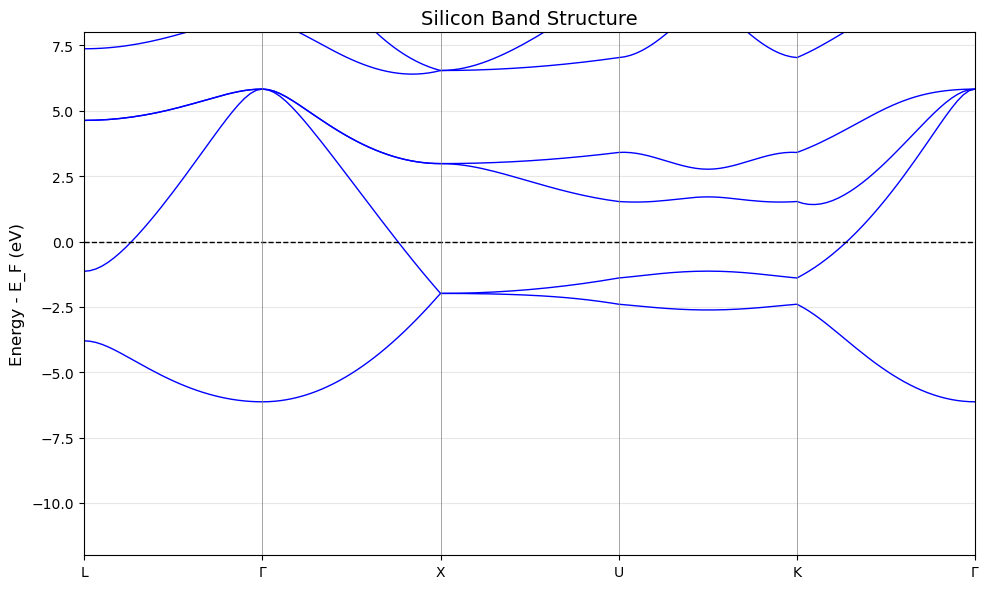

In [5]:
if HAS_MATPLOTLIB:
    print("Step 4: Plotting band structure")
    print()

    fig, ax = plt.subplots(figsize=(10, 6))

    # Shift bands relative to Fermi level
    bands_shifted = eigenvalues - fermi

    # Plot each band
    x = np.arange(len(kpath))
    for i in range(bands_shifted.shape[1]):
        ax.plot(x, bands_shifted[:, i], 'b-', linewidth=1)

    # Add Fermi level
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1, label='results/Fermi level')

    # Add vertical lines at high-symmetry points
    for pos in label_positions:
        ax.axvline(x=pos, color='gray', linestyle='-', linewidth=0.5)

    # Labels
    label_names = [r'$\Gamma$' if l == 'G' else l for l in labels]
    ax.set_xticks(label_positions)
    ax.set_xticklabels(label_names)

    ax.set_ylabel('Energy - E_F (eV)', fontsize=12)
    ax.set_title('Silicon Band Structure', fontsize=14)
    ax.set_xlim(0, len(kpath) - 1)
    ax.set_ylim(-12, 8)
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('silicon_bands.png', dpi=150)
    print("  Saved plot: silicon_bands.png")

print()
print("=" * 60)
print("Band structure calculation complete!")
print("=" * 60)
print()
print("Key points:")
print("  - Use non-self-consistent calculation (ICHARG=11)")
print("  - Define k-path through high-symmetry points")
print("  - Silicon is an indirect gap semiconductor")
print("  - VBM at Gamma, CBM near X")
print()
print("Next: Try 07_magnetism/ for spin-polarized calculations.")
